# Тестовое задание компании "Азбука мебели"

## Импорты, настройки, константы

In [1]:
# Загружаем основные библиотеки
import time
import math
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

# Импорт модулей для анализа временных рядов
from statsmodels.tsa.seasonal import seasonal_decompose

# Импортируем библиотеку optuna, для гиперпараметров
import optuna
from optuna.samplers import TPESampler

# Импорт модулей для создания пайплайна
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.compose import make_column_selector as selector

# Импорт модуля для разбивки данных на тренировочную и тестовую выборки и кроссвалидации
from sklearn.model_selection import train_test_split, cross_val_score, TimeSeriesSplit

# Импорт модулей для кодирования и масштабирования
from sklearn.preprocessing import (LabelEncoder,
                                   OneHotEncoder,
                                   OrdinalEncoder,
                                   StandardScaler, 
                                   MinMaxScaler, 
                                   RobustScaler, 
                                   FunctionTransformer)

# Импорт моделей машинного обучения
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from catboost import CatBoostClassifier, CatBoostRegressor

# Импорт модулей для создания пайплайна
from sklearn.compose import (ColumnTransformer,
                             make_column_selector)

# Импорт метрик
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
# Убираем необязательные предупреждения
import warnings
warnings.filterwarnings('ignore')

# Настраиваем отображение всех строк таблицы
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

# Задаём стандартне параметры для графиков
plt.rcParams['figure.figsize'] = (13, 5)
plt.rcParams.update({'font.size':'10'})

# Скрываем журнал с триалами
optuna.logging.set_verbosity(optuna.logging.WARNING)

In [3]:
# Создание констант
RANDOM_STATE = 39

## Функции и классы

### Функция для вывода распределения категориального признака

In [4]:
def show_cat_feature(df, feature, 
                     feature_name='', 
                     cut_count_to_barplot=5):
    '''
        Строит круговую диаграмму или барплот для категориального признака.
        Показывает статистические параметры.
        
        Args:
            df (pandas.DataFrame) - датафрейм, в котором находится признак
            feature (str) - название признака
            feature_name (str, optional) - имя признака для подписи графика default feature_name=feature
            cut_count_to_barplot (int, optional) - минимальное количество категорий для построения барплота 
                default cut_count_to_barplot=5
    '''
    
    # Ставим дефолтное название признака для подписи графика
    if feature_name == '':
        feature_name = feature
    
    # Создадим сводную таблцу для построения гистограммы или барплота
    pivot = df.pivot_table(index=feature, values='ID', aggfunc='count')
    pivot.columns = ['customers']
    pivot = pivot.sort_values(by='customers')
    
    # Строим круговую диаграмму, если категорий меньше 5
    if len(pivot) < cut_count_to_barplot:
        # Создаём фигуру и ось
        fig, ax = plt.subplots()
        # Подписываем диаграмму
        ax.set_title(feature_name, fontsize=11)
        # Отрисовываем диаграмму
        ax.pie(pivot['customers'], 
               labels=pivot.index, 
               autopct='%1.2f%%',
               explode=([0.03] * len(pivot)))
    
    # Строим барплот, если категорий больше или равно 5
    else:
        # Создаём фигуру и оси
        fig, ax = plt.subplots(figsize=(6, 2))
        # Устанавливаем размер шрифта
        plt.rcParams.update({'font.size': 9})
        # Наносим сетку, подписываем оси
        ax.grid(axis='x')
        ax.set(title=feature_name,
               xlabel='количество записей')
        # Отрисосываем графики
        ax.barh(pivot.index, pivot['customers'], linewidth=1.0, edgecolor='k', height=0.7)
    
    # Выводим график на экран
    plt.show()

### Функция для вывода гистограммы распределения количественного признака

In [5]:
def show_num_feature(df, feature, 
                     feature_name='', 
                     bins=100,
                     boxplot_flag=True,
                     describe_flag=True):
    '''
        Строит гистограмму распределения и ящик с усами для количественного признака.
        Показывает статистические параметры.
        
        Args:
            df (pandas.DataFrame) - датафрейм, в котором находится признак
            feature (str) - название признака
            feature_name (str, optional) - имя признака для подписи графика default feature_name=feature
            bins (int, optional) - количество корзин на гистограмме default bins=100
            boxplot_flag (bool, optional) - показывать ящик с усами default boxplot_flag=True
            describe_flag (bool, optional) - показывать ящик с усами default describe_flag=True
    '''
    
    # Устанавливаем размер шрифта
    plt.rcParams.update({'font.size': 9})
    
    # Ставим дефолтное название признака для подписи графика
    if feature_name == '':
        feature_name = feature
    
    # Задаём фигуру и оси
    if boxplot_flag:
        fig, axs = plt.subplots(2, 1, figsize=(8, 4))
        ax_1 = axs[0]
        ax_2 = axs[1]
    else:
        fig, ax_1 = plt.subplots(1, 1, figsize=(8, 2))
    
    # Отрисовываем гистограмму
    ax_1.set_title(f'Гистограмма распределения для признака: {feature_name}', fontsize=11)
    ax_1.set_xlabel(f'{feature_name}')
    ax_1.set_ylabel('количество записей', fontsize=9)
    ax_1.grid()
    ax_1.hist(df[feature], bins=bins, linewidth=1.0, edgecolor='k')
    
    # Отрисовываем ящик с усами, если стоит флаг 
    if boxplot_flag:
        ax_2.set_title(f'Ящик с усами для признака: {feature_name}', fontsize=9)
        ax_2.set_xlabel(f'{feature_name}', fontsize=9)
        ax_2.grid()
        ax_2.boxplot(df[feature], vert=False)
    
    # Добавляем строчку, что бы не перекрывались подписи осей
    plt.tight_layout(pad=2.0)
        
    # Выводим график на экран
    plt.show()
    
    # Смотрим статистические параметры
    if boxplot_flag:
        display(pd.DataFrame(df[feature].describe()))

## Функция для вывода гистограммы распределения дат

In [6]:
def show_date_feature(df, feature, 
                      feature_name='', 
                      bins=100,
                      boxplot_flag=True,
                      describe_flag=True):
    '''
        Строит гистограмму распределения и ящик с усами для временного признака.
        Показывает статистические параметры.
        
        Args:
            df (pandas.DataFrame) - датафрейм, в котором находится признак
            feature (str) - название признака
            feature_name (str, optional) - имя признака для подписи графика default feature_name=feature
            bins (int, optional) - количество корзин на гистограмме default bins=100
            boxplot_flag (bool, optional) - показывать ящик с усами default boxplot_flag=True
            describe_flag (bool, optional) - показывать статистические параметры default describe_flag=True
    '''
    
    # Устанавливаем размер шрифта
    plt.rcParams.update({'font.size': 9})
    
    # Ставим дефолтное название признака для подписи графика
    if feature_name == '':
        feature_name = feature
    
    # Задаём фигуру и оси
    if boxplot_flag:
        fig, axs = plt.subplots(2, 1, figsize=(8, 4))
        ax_1 = axs[0]
        ax_2 = axs[1]
    else:
        fig, ax_1 = plt.subplots(1, 1, figsize=(8, 2))
    
    # Отрисовываем гистограмму
    ax_1.set_title(f'Гистограмма распределения для признака: {feature_name}', fontsize=11)
    ax_1.set_xlabel(f'{feature_name}')
    ax_1.set_ylabel('количество записей', fontsize=9)
    ax_1.grid()
    ax_1.hist(df[feature], bins=bins, linewidth=1.0, edgecolor='k')
    
    # Отрисовываем ящик с усами, если стоит флаг 
    if boxplot_flag:
        ax_2.set_title(f'Ящик с усами для признака: {feature_name}', fontsize=9)
        ax_2.set_xlabel(f'{feature_name}', fontsize=9)
        ax_2.grid()
        ax_2.boxplot(df[feature].apply(lambda x: x.toordinal()), vert=False)  # Преобразуем даты в числовой формат для boxplot
    
    # Добавляем строчку, что бы не перекрывались подписи осей
    plt.tight_layout(pad=2.0)
        
    # Выводим график на экран
    plt.show()
    
    # Смотрим статистические параметры
    if describe_flag:
        display(pd.DataFrame(df[feature].describe()))

## Загрузка данных

In [7]:
# Загружаем данные
try:
    data = pd.read_csv('synthetic_sales_data.csv', parse_dates=['Date'])
    print(f'Размер датафрейма: {data.shape}')
except:
    print('Данные не были загружены.')

Размер датафрейма: (10000, 10)


In [8]:
# Меняем название столдбца
data = data.rename(columns={'Product_ID': 'ID'})

In [9]:
# Просмотр общей информации
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   ID        10000 non-null  object        
 1   Category  10000 non-null  object        
 2   Sales     10000 non-null  float64       
 3   Date      10000 non-null  datetime64[ns]
 4   Stock     10000 non-null  int64         
 5   Price     10000 non-null  float64       
 6   Color     10000 non-null  object        
 7   Type      10000 non-null  object        
 8   Discount  10000 non-null  float64       
 9   Region    10000 non-null  object        
dtypes: datetime64[ns](1), float64(3), int64(1), object(5)
memory usage: 781.4+ KB


In [10]:
# Смотрим датафрейм
data.head(3)

,ID,Category,Sales,Date,Stock,Price,Color,Type,Discount,Region
0,P00001,Bed,92.86,2022-07-31,115,1750.67,Green,Plastic,0.38,East
1,P00002,Sofa,23.98,2022-02-26,348,1747.14,White,Plastic,0.28,North
2,P00003,Bed,16.53,2022-10-31,440,1117.29,Red,Metal,0.10,North


## Предобработка данных

### Проверка на наличие пропусков и дубликатов

In [11]:
# Проверка на наличие пропусков
data.isna().sum()

ID          0
Category    0
Sales       0
Date        0
Stock       0
Price       0
Color       0
Type        0
Discount    0
Region      0
dtype: int64

In [12]:
# Проверка на наличие дубликатов
data.duplicated().sum()

0

In [23]:
# Проверка на дубликаты, исключая столбец 'ID'
data.duplicated(subset=data.columns.difference(['ID'])).sum()

0

### Распределение категориальных признаков

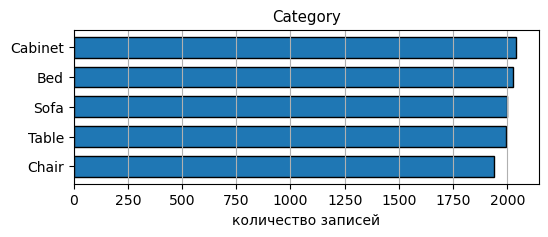

In [13]:
show_cat_feature(data, 'Category')

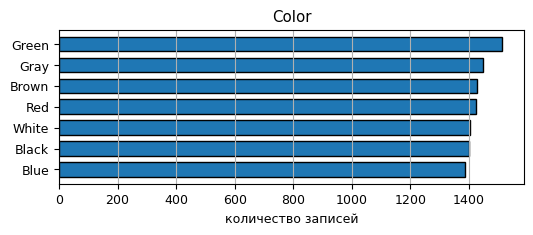

In [14]:
show_cat_feature(data, 'Color')

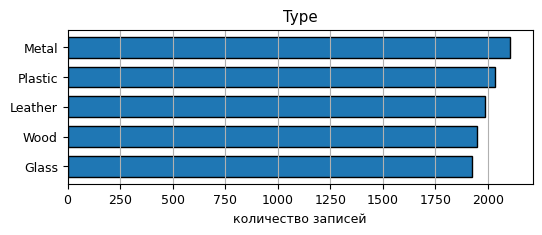

In [15]:
show_cat_feature(data, 'Type')

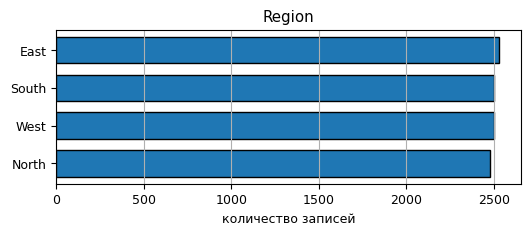

In [16]:
show_cat_feature(data, 'Region', cut_count_to_barplot=4)

### Распределение количественных признаков

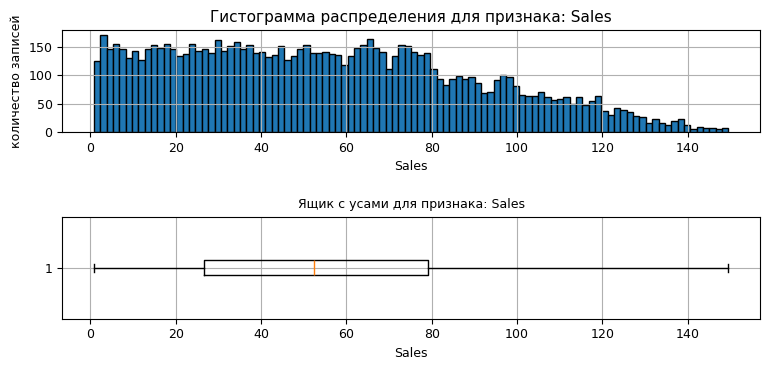

,Sales
count,10000.000000
mean,55.278037
std,34.458184
min,0.820000
25%,26.675000
50%,52.350000
75%,79.055000
max,149.530000


In [17]:
show_num_feature(data, 'Sales')

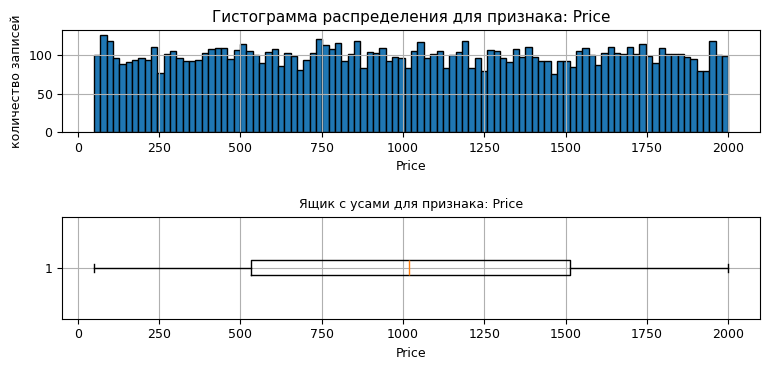

,Price
count,10000.00000
mean,1020.49415
std,562.85014
min,50.08000
25%,531.88500
50%,1017.03000
75%,1513.67500
max,1999.99000


In [18]:
show_num_feature(data, 'Price')

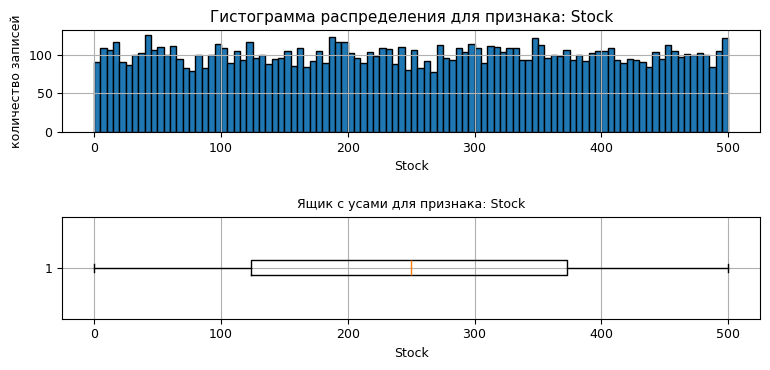

,Stock
count,10000.000000
mean,249.645100
std,144.516939
min,0.000000
25%,124.000000
50%,250.000000
75%,373.000000
max,500.000000


In [19]:
show_num_feature(data, 'Stock')

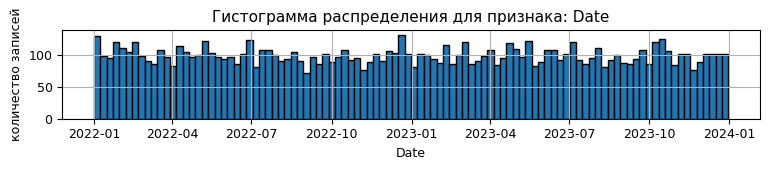

,Date
count,10000
mean,2022-12-28 21:44:38.400000
min,2022-01-01 00:00:00
25%,2022-06-26 00:00:00
50%,2022-12-29 00:00:00
75%,2023-06-29 00:00:00
max,2023-12-31 00:00:00


In [37]:
show_date_feature(data, 'Date', boxplot_flag=False)

**Итог:** 

- В данных нет пропесков, отсутствуют дубликаты и аномальные значения.
- Представлены данные за 2022 и 2023 годы.

## Исследовательский анализ

### Определение сезонности

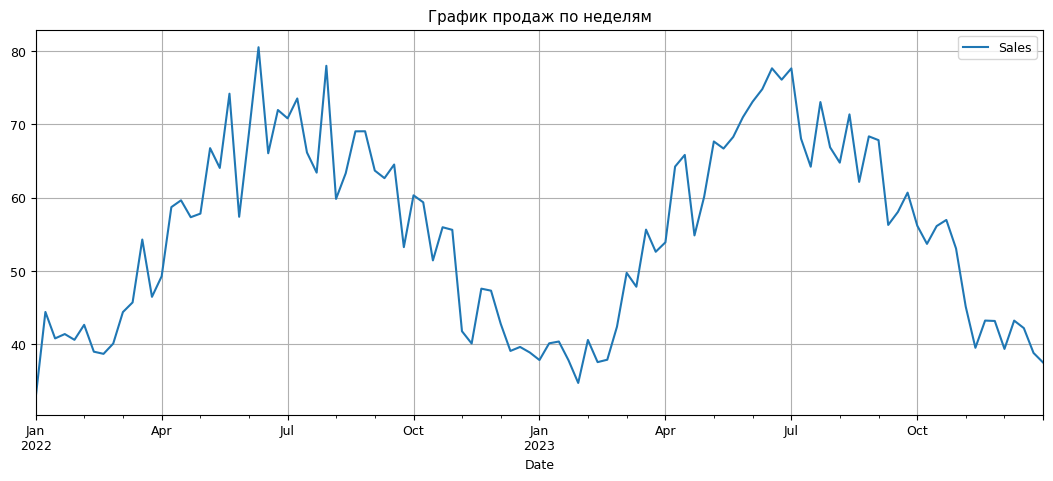

In [38]:
data[['Sales', 'Date']].set_index('Date').resample('1W').mean().plot()
plt.title('График продаж по неделям')
plt.grid()
plt.show()

In [28]:
# Указываем дату для фильтрации
target_date = '2022-01-31'

# Фильтруем данные по указанной дате
filtered_data = data[data['Date'] == target_date]

# Выводим результат
display(filtered_data)

,ID,Category,Sales,Date,Stock,Price,Color,Type,Discount,Region
1504,P01505,Sofa,3.19,2022-01-31,251,227.46,Black,Leather,0.28,West
1625,P01626,Bed,16.23,2022-01-31,446,545.44,Brown,Leather,0.38,North
1664,P01665,Sofa,55.40,2022-01-31,7,1547.34,Black,Leather,0.03,North
1677,P01678,Sofa,66.81,2022-01-31,71,1050.75,Black,Plastic,0.35,East
2170,P02171,Cabinet,8.14,2022-01-31,433,676.65,White,Plastic,0.13,East
3118,P03119,Chair,46.92,2022-01-31,481,354.03,Brown,Wood,0.34,East
5849,P05850,Chair,75.87,2022-01-31,124,597.23,Red,Wood,0.00,North
5896,P05897,Cabinet,10.44,2022-01-31,430,905.28,Blue,Plastic,0.32,North
6288,P06289,Chair,26.64,2022-01-31,321,1318.08,Red,Metal,0.03,West
6620,P06621,Bed,51.58,2022-01-31,130,929.56,Gray,Leather,0.28,East


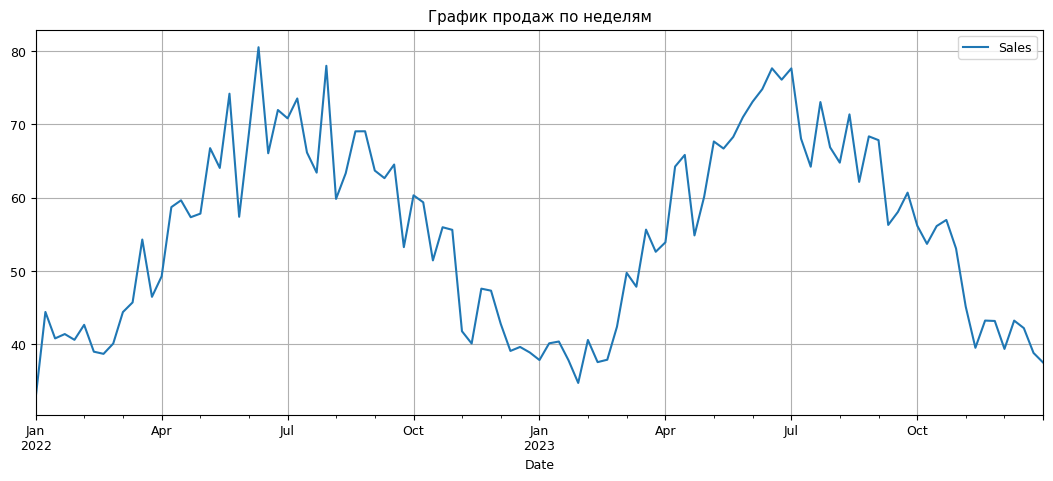

In [ ]:
data[['Sales', 'Date']].set_index('Date').resample('1W').mean().plot()
plt.title('График продаж по неделям')
plt.grid()
plt.show()